In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [38]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,3600.0,3600.0,3600.0,36 months,13.99%,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,24700.0,24700.0,24700.0,36 months,11.99%,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,20000.0,20000.0,20000.0,60 months,10.78%,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,35000.0,35000.0,35000.0,60 months,14.85%,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,10400.0,10400.0,10400.0,60 months,22.45%,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical colummn and see what happens off of this kind of naive approach.

In [40]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#rfc = ensemble.RandomForestClassifier()
#X = y2015.drop('loan_status', 1)
#Y = y2015['loan_status']
#X = pd.get_dummies(X)

#cross_val_score(rfc, X, Y, cv=5)

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [41]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
2
term
2
int_rate
111
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
2
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
51
next_pymnt_d
7
last_credit_pull_d
52
application_type
2
verification_status_joint
1
hardship_flag
2
hardship_type
1
hardship_reason
9
hardship_status
3
hardship_start_date
26
hardship_end_date
27
payment_plan_start_date
27
hardship_loan_status
4
disbursement_method
1
debt_settlement_flag
2
debt_settlement_flag_date
44
settlement_status
3
settlement_date
47


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [42]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [43]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
421092,NaN,NaN,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421093,NaN,NaN,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421094,NaN,NaN,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

Now this should be better. Let's try again.

In [87]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,settlement_date_Nov-2017,settlement_date_Nov-2018,settlement_date_Oct-2015,settlement_date_Oct-2016,settlement_date_Oct-2017,settlement_date_Oct-2018,settlement_date_Sep-2015,settlement_date_Sep-2016,settlement_date_Sep-2017,settlement_date_Sep-2018
0,NaN,NaN,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,...,0,0,0,0,0,0,0,0,0,0
5,NaN,NaN,11950.0,11950.0,11950.0,13.44,405.18,34000.0,10.20,0.0,...,0,0,0,0,0,0,0,0,0,0
6,NaN,NaN,20000.0,20000.0,20000.0,9.17,637.58,180000.0,14.67,0.0,...,0,0,0,0,0,0,0,0,0,0
7,NaN,NaN,20000.0,20000.0,20000.0,8.49,631.26,85000.0,17.61,1.0,...,0,0,0,0,0,0,0,0,0,0
8,NaN,NaN,10000.0,10000.0,10000.0,6.49,306.45,85000.0,13.07,0.0,...,0,0,0,0,0,0,0,0,0,0
9,NaN,NaN,8000.0,8000.0,8000.0,11.48,263.74,42000.0,34.80,0.0,...,0,0,0,0,0,0,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [88]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

array([0.98931446, 0.99076273, 0.9902636 , 0.99130827, 0.99244817,
       0.99199696, 0.99256691, 0.99147451, 0.99223444, 0.99114141])

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [72]:
# Your code here.



In [73]:
#sns.heatmap(y2015.corr())
#plt.show()

In [74]:
# Take a subset of the data for PCA and drop missing values because PCA cannot
# handle them. We could also impute, but missingness is quite low so dropping
# missing rows is unlikely to create bias.
df_pca = X

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X_norm = StandardScaler().fit_transform(df_pca)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X_norm.T
Cx = np.cov(Xt)
#print('Covariance Matrix:\n', Cx)

/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [75]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)
print(eig_vec_cov.shape)

(393, 393)


In [76]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
#for i in range(len(eig_val_cov)):
    #eigvec_cov = eig_vec_cov[:, i].reshape(1, 448).T
    #print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    #print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    #print(40 * '-')

#print(
    #'The percentage of total variance in the dataset explained by each',
    #'component calculated by hand.\n',
    #eig_val_cov / sum(eig_val_cov)
#)

/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


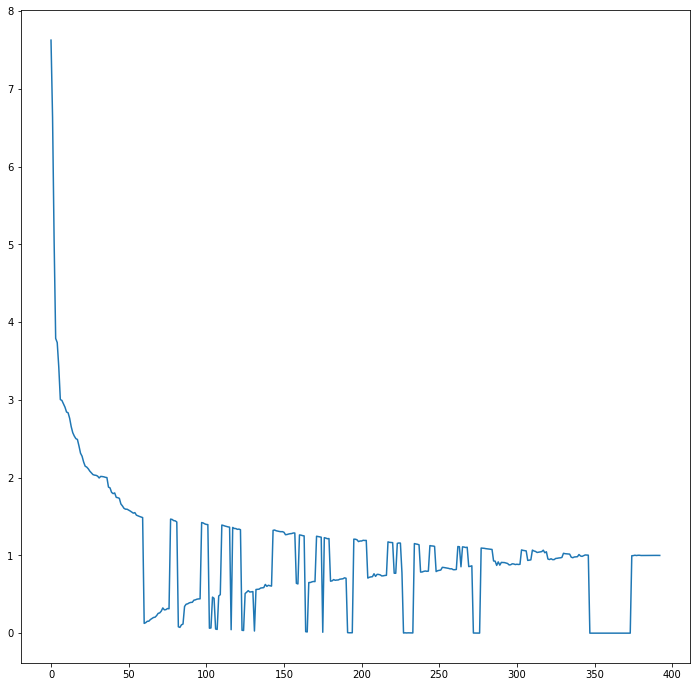

In [77]:
plt.figure(figsize=(12,12))
plt.plot(eig_val_cov)
plt.show()

In [98]:
from sklearn.decomposition import PCA
X = y2015.drop('loan_status', 1)
X = pd.get_dummies(X)
X = X.dropna(axis=1)
pca = PCA(n_components=11)
pca.fit(X)
X_pca = pca.transform(X)
print(X_pca.shape)

(421095, 11)


In [99]:
y2015['loan_status'].shape

(421095,)

In [100]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = X_pca
Y = y2015['loan_status']

cross_val_score(rfc, X, Y, cv=10)

/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/nickdelucchi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

array([0.91038397, 0.92090141, 0.92678699, 0.9345983 , 0.93892042,
       0.94343252, 0.94167518, 0.9402978 , 0.93504951, 0.92257635])